# Install of Julia
only needed if not already installed

---

run one time and reload the page then proceed to "Installing needed packeges"

In [ ]:
%%shell
set -e

VERSION="1.5.3"
# if the VERSION is altered the metadata of the notebook itself 
# (open the .ipynb file with a text editor [line 20]) has to be altered as well
# otherwise highlighting and autocompletion won't work

#-------------------------------------------------------------------------------

if [ -z `which julia` ]; then
  echo "Julia not found installing ..."
  URL="https://julialang-s3.julialang.org/bin/linux/x64/$(cut -d '.' -f -2 <<< "$VERSION")/julia-$VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  julia -e 'using Pkg; pkg"add IJulia; precompile;"'

  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict("JULIA_NUM_THREADS"=>"'"8"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo "Finished"
fi

Julia not found installing ...
2021-03-29 02:16:02 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz [105260711/105260711] -> "/tmp/julia.tar.gz" [1]
 Installing known registries into `~/.julia`
######################################################################## 100.0%
      Added registry `General` to `~/.julia/registries/General`
  Resolving package versions...
  Installed Conda ─────────── v1.5.1
  Installed VersionParsing ── v1.2.0
  Installed ZeroMQ_jll ────── v4.3.2+6
  Installed libsodium_jll ─── v1.0.18+1
  Installed SoftGlobalScope ─ v1.1.0
  Installed MbedTLS ───────── v1.0.3
  Installed Parsers ───────── v1.1.0
  Installed ZMQ ───────────── v1.2.1
  Installed IJulia ────────── v1.23.2
  Installed JSON ──────────── v0.21.1
  Installed JLLWrappers ───── v1.2.0
  Installed Artifacts ─────── v1.3.0
  Installed MbedTLS_jll ───── v2.16.8+1
######################################################################## 100.0%
############

# Installing needed packages
For SciBert Cuda Flux and Transformers get installed

as well as loading them

and setting some env variables

In [ ]:
using Pkg
Pkg.add("CUDA")
Pkg.add("Flux")
Pkg.add("Transformers")
Pkg.add("DataDeps")
Pkg.add("DataFrames")
Pkg.add("JSON3")
Pkg.add("Metrics")
Pkg.add("BenchmarkTools")
Pkg.add("StatsPlots")

using Printf
using DataFrames
using JSON3
using CUDA
using Metrics
using Transformers
using Transformers.Basic
using Transformers.Pretrain
using DataDeps
using BenchmarkTools
using Flux
using Flux: onehotbatch,onehot,onecold,gradient,params,logitcrossentropy
using Flux.Optimise: update!
using StatsPlots

enable_gpu(true)
ENV["DATADEPS_ALWAYS_ACCEPT"] = true

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

true

defining the needed data

In [ ]:
register(DataDep("SciBert",
    """
    Dataset: SciBERT
    Website: https://github.com/allenai/scibert
    """
    ,
    "https://codeload.github.com/allenai/scibert/zip/master",
    post_fetch_method = file ->(unpack(file),
                        #replace(file, ".zip" => "") ,
                        print(file,"\n"),
                        print("$(SubString(file,1,findlast(==('.'),file).-1))/data/\n"),
                        print(SubString.(file,1,findlast.(==('/'),file)), "\n"),
                        mv("$(SubString.(file,1,findlast.(==('.'),file).-1))/data/","$(SubString.(file,1,findlast.(==('/'),file)))/data" ))
))

┌ Warning: Over-writing registration of the datadep
│   name = SciBert
└ @ DataDeps /root/.julia/packages/DataDeps/ooWXe/src/registration.jl:15


DataDep{Nothing,String,typeof(DataDeps.fetch_default),var"#47#48"}("SciBert", "https://codeload.github.com/allenai/scibert/zip/master", nothing, DataDeps.fetch_default, var"#47#48"(), "Dataset: SciBERT\nWebsite: https://github.com/allenai/scibert\n")

In [ ]:
df = JSON3.read.(eachline(datadep"SciBert/data/text_classification/chemprot/train.txt")) |> DataFrame
test = JSON3.read.(eachline(datadep"SciBert/data/text_classification/chemprot/test.txt")) |> DataFrame
@show

# Required functions


1.   loss function
2.   train function
3.   tokenize function
4.   score function (for calculating F1 score)

In [ ]:
#define the loss
function loss(data, label, mask=nothing,silenced = true)

    e = model.embed(data)
    t = model.transformers(e, mask)
    prediction = model.classifier.clf(
                    model.classifier.pooler(
                        t[:,1,:]
                    )
                )
    loss = Flux.logitcrossentropy(
              prediction,
              label
          )

    if !silenced && isnan(loss)
        println("Loss is NAN !")
        @show data
        @show prediction
        @show label
        @show loss
        flush(stdout)
    end

    return loss
end

loss (generic function with 3 methods)

In [ ]:
function tokenize(sentence,label)
    attention_start = findfirst("<<",sentence)[1]
    attention_end  = findfirst(">>", sentence)[1]

    token_start = findfirst("[[", sentence)[1]
    token_end = findfirst("]]", sentence)[1]

    if attention_start < token_start
      b = split(sentence, r"<<|>>|\[\[|\]\]")

      output = ["[CLS]";b[1]|>tokenizer |> wordpiece; "[<<]" ;
        b[2]|>tokenizer|> wordpiece; "[>>]";
        b[3]|>tokenizer|> wordpiece; "[[[]";
        b[4]|>tokenizer|> wordpiece; "[]]]";
        b[5]|>tokenizer|> wordpiece ;"[SEP]"]
    else
      b = split(sentence, r"<<|>>|\[\[|\]\]")
      output = ["[CLS]";b[1]|>tokenizer|> wordpiece; "[[[]";
        b[2]|>tokenizer|> wordpiece; "[]]]";
        b[3]|>tokenizer |> wordpiece; "[<<]" ;
        b[4]|>tokenizer|> wordpiece; "[>>]";
        b[5]|>tokenizer|> wordpiece ;"[SEP]"]
    end


    tok = vocab(output)
    segment = fill!(similar(tok), 1)
    label = onehot(label, labels)
    mask = getmask([output])

    return (tok=tok, segment=segment), label, mask
end

tokenize (generic function with 1 method)

the actual training function
it uses the model previously saved under the name model and calculates some stats per epoch

In [ ]:
function train!(silenced = false)
  test_sentence = test[!,"text"]
  test_label = test[!,"label"]
  F_1[1] = compute_F1(test_sentence,test_label)
  @printf( "F_1 Score %0.3f before training \n",F_1[1])
  flush(stdout)

  for epoch ∈ 1:epochs
  
    # log memory throughput and time required per epoch
    memory[epoch]=(CUDA.@allocated begin 
      time[epoch]=(CUDA.@timed begin

        for i ∈ 1:data_size
          sentence = df[!,"text"][i]
          label = df[!,"label"][i]

          #moving the needed data to the gpu
          data, label, mask = todevice(
            tokenize(sentence,label)
          )

          #compute loss and save for later
          
          
          # old version of the gradient calculation (does not work anymore)
          # grad = gradient(()->loss(data, label, mask), ps)

          # new version of the gradient calculation
          local training_loss
          grad = gradient(ps) do

            training_loss = loss(data, label, mask,silenced)
            training_loss
          end

          losses[epoch,i] = training_loss

          # update the model weights
          if silenced === false && isnan(training_loss)
            @printf( "Iteration number %0.0f produced NAN \n",i)
            continue
          end

          update!(opt, ps, grad)
        end

      end)[:time]
    end)

    F_1[epoch+1] = compute_F1(test_sentence,test_label)
    @printf( "Stats for epoch %0.0f: used GPU memory: %s; Time needed %0.3f seconds; F_1 Score %0.3f\n",epoch , Base.format_bytes(memory[epoch]),time[epoch],F_1[epoch])
    flush(stdout)
  end
end

train! (generic function with 2 methods)

Function for computing of F1 Score 
defaults to micro but can be changed to macro if needed

In [ ]:
function compute_F1(sentence,label, avg_type = "micro")
    Flux.testmode!(model)
    size = length(labels)

    y_pred = Array{Float64}(undef,size, 0)
    y_true = Array{Float64}(undef,size, 0)

    for i ∈ 1:length(sentence)
      flush(stdout)
      data, label_ignore, mask = todevice( #move data to gpu
                            tokenize(sentence[i],label[i])
                          )
      e =           model.embed(data)
      t =           model.transformers(e, mask)
      prediction =  model.classifier.clf(
                      model.classifier.pooler(
                        t[:,1,:]
                      )
                    )

      buffer_pred = Array(prediction)
      y_pred = hcat(y_pred,buffer_pred)

      pos = findall(x->x==label[i], labels)

      buffer_true = Metrics.onehot_encode(pos[1]-1, 0:size-1)
      y_true = hcat(y_true,buffer_true)
    end

    Flux.testmode!(model, false)

    return f_beta_score(y_pred, y_true; avg_type)
end

compute_F1 (generic function with 2 methods)

# Examples

Loading and Reading the Dataset

In [ ]:
@printf "printing column names of the train data:\n"
@show names(df)

@printf "\n\nfirst five labels of the training data:\n"
@show df[!,"label"][1:5]

@printf "\n\nfirst text of the training data:\n"
@show df[!,"text"][1]
@show

printing column names of the train data:
names(df) = ["text", "label", "metadata"]


first five labels of the training data:
(df[!, "label"])[1:5] = ["INHIBITOR", "INHIBITOR", "INHIBITOR", "INHIBITOR", "INHIBITOR"]


first text of the training data:
(df[!, "text"])[1] = "<< Epidermal growth factor receptor >> inhibitors currently under investigation include the small molecules [[ gefitinib ]] (Iressa, ZD1839) and erlotinib (Tarceva, OSI-774), as well as monoclonal antibodies such as cetuximab (IMC-225, Erbitux)."


Testing the tokenizer with a sentence and the corresponding label from the training dataset

In [ ]:
df[!,"text"][500]

("Moreover, recent in vitro studies suggest that << memantine >> abrogates beta-amyloid ([[ Abeta ]]) toxicity and possibly inhibits Abeta production.", "DOWNREGULATOR")

In [ ]:
vocab("memantine"|>tokenizer|> wordpiece)

3-element Array{Int64,1}:
  920
 1529
  712

In [ ]:
vocab("Abeta"|>tokenizer|> wordpiece)

2-element Array{Int64,1}:
 29571
 30111

In [ ]:
vocab("[>>]]")

102

here we can see that the two text sections are correctly delimited by the special tokens (said special tokens have the number 102)

In [ ]:
@show tokenize(df[!,"text"][500],df[!,"label"][500])

tokenize((df[!, "text"])[500], (df[!, "label"])[500]) = ((tok = [103, 2429, 423, 2152, 122, 3336, 827, 1740, 199, 102, 920, 1529, 712, 102, 23703, 458, 6131, 580, 12250, 146, 102, 29571, 30111, 102, 547, 6007, 138, 5780, 9234, 29571, 30111, 1866, 206, 104], segment = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), Bool[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], Float32[1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0])


((tok = [103, 2429, 423, 2152, 122, 3336, 827, 1740, 199, 102  …  547, 6007, 138, 5780, 9234, 29571, 30111, 1866, 206, 104], segment = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), Bool[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], Float32[1.0 1.0 … 1.0 1.0])

the following provides an example of how crossentropy works

In [ ]:
# label
y = onehotbatch([1, 1, 0, 0], 0:1)
# prediction
ŷ = [.1 .9; .9 .1; .9 .1; .1 .9]'

crossentropy(ŷ, y)
#should be 1.203972804325936

1.2039728043259346

exemplary training step (requires a GPU)

In [ ]:
@show df[!,"text"][2096]
@show df[!,"label"][2096]
data ,label, mask = tokenize(df[!,"text"][2096],df[!,"label"][2096]) |> todevice
@show "moved"
e = model.embed(data)
t = model.transformers(e, mask)
@show t[:,1,:]
@show prediction = model.classifier.clf(
                    model.classifier.pooler(
                        t[:,1,:]
                    )
                )
Flux.logitcrossentropy(
              prediction,
              label
          )

(df[!, "text"])[2096] = "Also, << vinblastine >> enhances the phosphorylation of Ras homologous protein A, the accumulation of reactive oxygen species, the release of intracellular Ca(2+), as well as the activation of apoptosis signal-regulating kinase 1, c-jun-N-terminal kinase, p38, inhibitor of kappaBα (IκBα) kinase, and [[ inositol requiring enzyme 1α ]]."
(df[!, "label"])[2096] = "ACTIVATOR"
"moved" = "moved"
t[:, 1, :] = Float32[0.2478134; 0.2782201; -0.3860827; 0.29328388; 0.20098038; 0.72138953; 0.06467727; 0.19848606; 0.11086153; 0.14420938; -0.394287; -0.17296514; 0.6641791; -0.33261013; 0.020392526; -0.2557727; 0.08250428; -0.14382252; 0.1492463; -0.3899335; 0.059584364; 0.2405193; 0.4118689; -0.41256005; -0.17261076; 0.6605498; 0.66683656; 0.50374043; 0.43102586; 0.063245654; 0.032795522; 0.17241384; -0.39730376; 0.8076685; 0.3442052; 0.27087495; -0.012099674; 0.55241126; 0.07490455; 0.07549773; 0.27067804; -0.40820616; 0.16340198; 0.15055408; -0.15163916; 0.05747789; -0.01

3.1486564f0

Test for the reformating for the F1 Score

In [ ]:
labels = unique(df[!,"label"])
labels

13-element Array{String,1}:
 "INHIBITOR"
 "ANTAGONIST"
 "AGONIST"
 "DOWNREGULATOR"
 "PRODUCT-OF"
 "SUBSTRATE"
 "INDIRECT-UPREGULATOR"
 "UPREGULATOR"
 "INDIRECT-DOWNREGULATOR"
 "ACTIVATOR"
 "AGONIST-ACTIVATOR"
 "AGONIST-INHIBITOR"
 "SUBSTRATE_PRODUCT-OF"

In [ ]:
@show test_label = test[!,"label"][1]

pos = findall(x->x==test_label, labels)
buffer_true = Metrics.onehot_encode(pos[1], 0:length(labels))

test_label = (test[!, "label"])[1] = "ANTAGONIST"


14×1 Array{Float64,2}:
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

# REL Experiments


## uncased scibert model with scivocab

### loading the model and exchanging the classification layer

Loading the Pretrained Model

In [ ]:
model, wordpiece, tokenizer = pretrain"Bert-scibert_scivocab_uncased"

┌ Info: loading pretrain bert model: scibert_scivocab_uncased.tfbson 
└ @ Transformers.BidirectionalEncoder /root/.julia/packages/Transformers/lFBL6/src/bert/load_pretrain.jl:8


(TransformerModel{Bert{Stack{NTuple{12,Transformer{Transformers.Basic.MultiheadAttention{Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dropout{Float64,Colon}},LayerNorm{typeof(identity),Flux.Diagonal{Array{Float32,1}},Float32,1},Transformers.Basic.PwFFN{Dense{typeof(gelu),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}},LayerNorm{typeof(identity),Flux.Diagonal{Array{Float32,1}},Float32,1},Dropout{Float64,Colon}}},Symbol("((x, m) => x':(x, m)) => 12")},Dropout{Float64,Colon}}}(
  embed = CompositeEmbedding(tok = Embed(768), segment = Embed(768), pe = PositionEmbedding(768, max_len=512), postprocessor = Positionwise(LayerNorm((768,)), Dropout(0.1))),
  transformers = Bert(layers=12, head=12, head_size=64, pwffn_size=3072, size=768),
  classifier = 
    (
      

defining all possible labels as labels

In [ ]:
vocab = Vocabulary(wordpiece)
labels = unique(df[!,"label"])

13-element Array{String,1}:
 "INHIBITOR"
 "ANTAGONIST"
 "AGONIST"
 "DOWNREGULATOR"
 "PRODUCT-OF"
 "SUBSTRATE"
 "INDIRECT-UPREGULATOR"
 "UPREGULATOR"
 "INDIRECT-DOWNREGULATOR"
 "ACTIVATOR"
 "AGONIST-ACTIVATOR"
 "AGONIST-INHIBITOR"
 "SUBSTRATE_PRODUCT-OF"

redefining the model, its parameters and the optimiser with the learning rate


In [ ]:
#defining clf layer with dropout
clf = Chain(
    Dropout(0.1),
    Dense(size(model.classifier.pooler.W ,1), length(labels))
)

#redefining the scibert model
model =gpu(
      Basic.set_classifier(model,
                    (
                        pooler = model.classifier.pooler,
                        clf = clf
                    )
                    )
  )
show(model)

TransformerModel{Bert{Stack{NTuple{12,Transformer{Transformers.Basic.MultiheadAttention{Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dropout{Float64,Colon}},LayerNorm{typeof(identity),Flux.Diagonal{CuArray{Float32,1}},Float32,1},Transformers.Basic.PwFFN{Dense{typeof(gelu),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}}},LayerNorm{typeof(identity),Flux.Diagonal{CuArray{Float32,1}},Float32,1},Dropout{Float64,Colon}}},Symbol("((x, m) => x':(x, m)) => 12")},Dropout{Float64,Colon}}}(
  embed = CompositeEmbedding(tok = Embed(768), segment = Embed(768), pe = PositionEmbedding(768, max_len=512), postprocessor = Positionwise(LayerNorm((768,)), Dropout(0.1))),
  transformers = Bert(layers=12, head=12, head_size=64, pwffn_size=3072, size=768),
 

### setting parameters and training the model


> after the training some stats get plotted




setting the learnrate and the optimizer

In [ ]:
ps = params(model)
opt = ADAM(2e-5)

ADAM(2.0e-5, (0.9, 0.999), IdDict{Any,Any}())

In [ ]:
CUDA.memory_status() 

Effective GPU memory usage: 99.98% (14.752 GiB/14.756 GiB)
CUDA allocator usage: 14.321 GiB
binned usage: 14.321 GiB (2.086 GiB allocated, 12.235 GiB cached)


Set the number of epochs, define some arrays in which intermediate results are stored and start the training

In [ ]:
epochs = 10
data_size = nrow(df)
losses= Array{Float64}(undef,epochs, data_size)
memory = Array{Float64}(undef,epochs, data_size)
time =  Array{Float64}(undef,epochs)
F_1 =  Array{Float64}(undef,epochs+1)

train!(true)

F_1 Score 0.012 before training 
Stats for epoch 1: used GPU memory: 2.510 TiB; Time needed 586.031 seconds; F_1 Score 0.012
Stats for epoch 2: used GPU memory: 2.509 TiB; Time needed 671.002 seconds; F_1 Score 0.084
Stats for epoch 3: used GPU memory: 2.509 TiB; Time needed 659.794 seconds; F_1 Score 0.084
Stats for epoch 4: used GPU memory: 2.509 TiB; Time needed 658.477 seconds; F_1 Score 0.084
Stats for epoch 5: used GPU memory: 2.509 TiB; Time needed 660.429 seconds; F_1 Score 0.084
Stats for epoch 6: used GPU memory: 2.509 TiB; Time needed 663.892 seconds; F_1 Score 0.084
Stats for epoch 7: used GPU memory: 2.509 TiB; Time needed 665.261 seconds; F_1 Score 0.084
Stats for epoch 8: used GPU memory: 2.509 TiB; Time needed 658.365 seconds; F_1 Score 0.084
Stats for epoch 9: used GPU memory: 2.509 TiB; Time needed 666.139 seconds; F_1 Score 0.084
Stats for epoch 10: used GPU memory: 2.509 TiB; Time needed 655.788 seconds; F_1 Score 0.084


In [ ]:
losses[2,1:1000]

1000-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [ ]:
CUDA.memory_status() 

Effective GPU memory usage: 99.98% (14.752 GiB/14.756 GiB)
CUDA allocator usage: 14.321 GiB
binned usage: 14.321 GiB (8.010 GiB allocated, 6.311 GiB cached)


In [ ]:
for epoch ∈ 1:epochs
    @show epoch
    @show mean(losses[epoch,:])
  end

epoch = 1
mean(losses[epoch, :]) = NaN
epoch = 2
mean(losses[epoch, :]) = NaN
epoch = 3
mean(losses[epoch, :]) = NaN
epoch = 4
mean(losses[epoch, :]) = NaN
epoch = 5
mean(losses[epoch, :]) = NaN
epoch = 6
mean(losses[epoch, :]) = NaN
epoch = 7
mean(losses[epoch, :]) = NaN
epoch = 8
mean(losses[epoch, :]) = NaN
epoch = 9
mean(losses[epoch, :]) = NaN
epoch = 10
mean(losses[epoch, :]) = NaN


Plot the training loss per epoch 

In [ ]:
y = transpose(losses[:,:])
boxplot(["Epoch 1" "Epoch 2" "Epoch 3" "Epoch 4" "Epoch 5" "Epoch 6" "Epoch 7" "Epoch 8" "Epoch 9" "Epoch 10"], y, leg = false)

LoadError: ignored

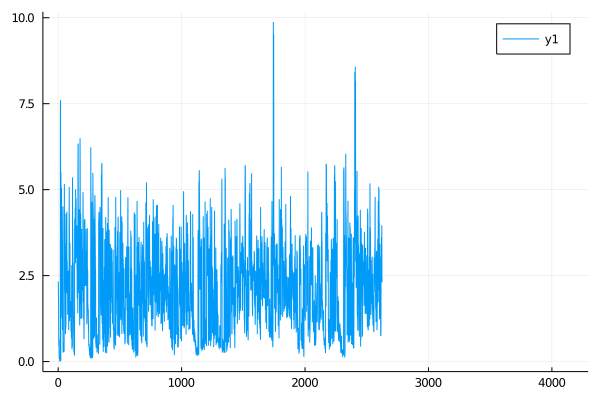

In [ ]:
plot(losses[1,:])

## cased scibert model with scivocab

### loading the model and exchanging the classification layer

Loading the Pretrained Model

In [ ]:
model, wordpiece, tokenizer = pretrain"Bert-scibert_scivocab_cased"

┌ Info: loading pretrain bert model: scibert_scivocab_cased.tfbson 
└ @ Transformers.BidirectionalEncoder /root/.julia/packages/Transformers/lFBL6/src/bert/load_pretrain.jl:8


(TransformerModel{Bert{Stack{NTuple{12,Transformer{Transformers.Basic.MultiheadAttention{Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},Dropout{Float64,Colon}},LayerNorm{typeof(identity),Flux.Diagonal{Array{Float32,1}},Float32,1},Transformers.Basic.PwFFN{Dense{typeof(gelu),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}},LayerNorm{typeof(identity),Flux.Diagonal{Array{Float32,1}},Float32,1},Dropout{Float64,Colon}}},Symbol("((x, m) => x':(x, m)) => 12")},Dropout{Float64,Colon}}}(
  embed = CompositeEmbedding(tok = Embed(768), segment = Embed(768), pe = PositionEmbedding(768, max_len=512), postprocessor = Positionwise(LayerNorm((768,)), Dropout(0.1))),
  transformers = Bert(layers=12, head=12, head_size=64, pwffn_size=3072, size=768),
  classifier = 
    (
      

defining all possible labels as labels

In [ ]:
vocab = Vocabulary(wordpiece)
labels = unique(df[!,"label"])

13-element Array{String,1}:
 "INHIBITOR"
 "ANTAGONIST"
 "AGONIST"
 "DOWNREGULATOR"
 "PRODUCT-OF"
 "SUBSTRATE"
 "INDIRECT-UPREGULATOR"
 "UPREGULATOR"
 "INDIRECT-DOWNREGULATOR"
 "ACTIVATOR"
 "AGONIST-ACTIVATOR"
 "AGONIST-INHIBITOR"
 "SUBSTRATE_PRODUCT-OF"

redefining the model, its parameters and the optimiser with the learning rate


In [ ]:
#defining clf layer with dropout
clf = Chain(
    Dropout(0.1),
    Dense(size(model.classifier.pooler.W ,1), length(labels))
)

#redefining the scibert model
model =gpu(
      Basic.set_classifier(model,
                    (
                        pooler = model.classifier.pooler,
                        clf = clf
                    )
                    )
  )
show(model)

TransformerModel{Bert{Stack{NTuple{12,Transformer{Transformers.Basic.MultiheadAttention{Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}},Dropout{Float64,Colon}},LayerNorm{typeof(identity),Flux.Diagonal{CuArray{Float32,1}},Float32,1},Transformers.Basic.PwFFN{Dense{typeof(gelu),CuArray{Float32,2},CuArray{Float32,1}},Dense{typeof(identity),CuArray{Float32,2},CuArray{Float32,1}}},LayerNorm{typeof(identity),Flux.Diagonal{CuArray{Float32,1}},Float32,1},Dropout{Float64,Colon}}},Symbol("((x, m) => x':(x, m)) => 12")},Dropout{Float64,Colon}}}(
  embed = CompositeEmbedding(tok = Embed(768), segment = Embed(768), pe = PositionEmbedding(768, max_len=512), postprocessor = Positionwise(LayerNorm((768,)), Dropout(0.1))),
  transformers = Bert(layers=12, head=12, head_size=64, pwffn_size=3072, size=768),
 

### setting parameters and training the model


setting the learnrate and the optimizer

In [ ]:
ps = params(model)
opt = ADAM(2e-5)

ADAM(2.0e-5, (0.9, 0.999), IdDict{Any,Any}())

In [ ]:
CUDA.memory_status() 

Effective GPU memory usage: 78.90% (11.643 GiB/14.756 GiB)
CUDA allocator usage: 9.369 GiB
binned usage: 9.369 GiB (9.369 GiB allocated, 0 bytes cached)


Set the number of epochs, define some arrays in which intermediate results are entered and start the training
data_size 

In [ ]:
epochs = 10
data_size = nrow(df)
losses= Array{Float64}(undef,epochs, data_size)
memory = Array{Float64}(undef,epochs, data_size)
time =  Array{Float64}(undef,epochs)
F_1 =  Array{Float64}(undef,epochs+1)

train!(true)

y_pred = [-0.20657509565353394 -0.20779746770858765 -0.20874783396720886 -0.18448659777641296 -0.18505607545375824 -0.18569983541965485 -0.18391241133213043 -0.1845703125 -0.18462307751178741 -0.1866939663887024 -0.18401578068733215 -0.21272802352905273 -0.15618890523910522 -0.18350471556186676 -0.1857706606388092 -0.18208423256874084 -0.18337519466876984 -0.15404820442199707 -0.24875062704086304 -0.202194482088089 -0.15980952978134155 -0.16003742814064026 -0.15962117910385132 -0.1597873419523239 -0.2148255705833435 -0.19054214656352997 -0.1920134425163269 -0.19476225972175598 -0.19364076852798462 -0.19621901214122772 -0.17369285225868225 -0.1801619678735733 -0.18777185678482056 -0.18751640617847443 -0.20415982604026794 -0.15321916341781616 -0.19723589718341827 -0.17351524531841278 -0.14332860708236694 -0.1438106894493103 -0.17735092341899872 -0.16903488337993622 -0.1564735770225525 -0.1562117636203766 -0.15600252151489258 -0.17003142833709717 -0.169768288731575 -0.17380283772945404 -0

In [ ]:
CUDA.memory_status() 

Effective GPU memory usage: 99.98% (14.752 GiB/14.756 GiB)
CUDA allocator usage: 14.321 GiB
binned usage: 14.321 GiB (10.256 GiB allocated, 4.065 GiB cached)


calculate the average loss per epoch

In [ ]:
for epoch ∈ 1:epochs
    @show epoch
    @show mean(losses[epoch,:])
  end

epoch = 1
mean(losses[epoch, :]) = 0.0
epoch = 2
mean(losses[epoch, :]) = 0.0
epoch = 3
mean(losses[epoch, :]) = 0.0
epoch = 4
mean(losses[epoch, :]) = 0.0
epoch = 5
mean(losses[epoch, :]) = 0.0
epoch = 6
mean(losses[epoch, :]) = 0.0
epoch = 7
mean(losses[epoch, :]) = 0.0
epoch = 8
mean(losses[epoch, :]) = 0.0
epoch = 9
mean(losses[epoch, :]) = 0.0
epoch = 10
mean(losses[epoch, :]) = 0.0


Plot the training loss per epoch 

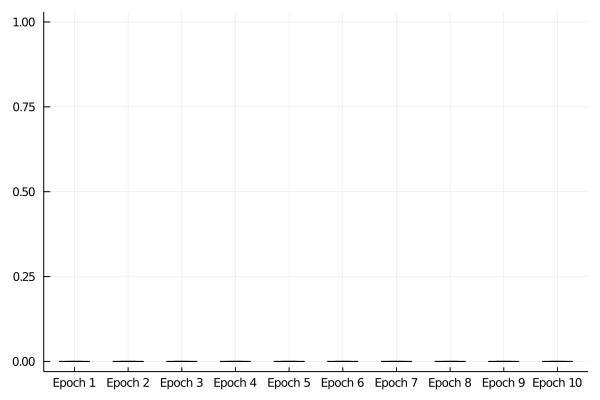

In [ ]:
y = transpose(losses[:,:])
boxplot(["Epoch 1" "Epoch 2" "Epoch 3" "Epoch 4" "Epoch 5" "Epoch 6" "Epoch 7" "Epoch 8" "Epoch 9" "Epoch 10"], y, leg = false)